# Laboratorio 1: Clasificación Binaria (Ciencia de Datos)

Notebook **completa** con todos los apartados: carga de datos, EDA, partición,
pipeline base (Regresión Logística), métricas, **validación cruzada y comparación de modelos**,
**ajuste de umbral**, **modelo final en test** y **explicabilidad**.


## 0. Requisitos e instrucciones

- Python 3.10+ con `pandas`, `numpy`, `scikit-learn`, `matplotlib`.
- Ejecuta las celdas **en orden** (usa `Restart & Run All` para reproducibilidad).
- Datos: `datos_clasificacion.csv` en la raíz. Si no está, se generarán datos sintéticos equivalentes.
- Entregables sugeridos:
  1. Notebook ejecutada (con gráficos y conclusiones).
  2. Breve informe (problema, método, resultados, discusión).
  3. Tabla de comparación de modelos (CV) con promedio ± desvío.


## 1. Cargar datos

In [3]:
# 1) Cargar datos
import os, pandas as pd, numpy as np
from sklearn.datasets import make_classification

DATA_PATHS = [
    "datos_clasificacion.csv",
    "./data/datos_clasificacion.csv",
    "/content/sample_data/datos_clasificacion.csv",
]

for p in DATA_PATHS:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Cargado: {p} - shape={df.shape}")
        break
df.head()


Cargado: datos_clasificacion.csv - shape=(1200, 17)


,feat_00,feat_01,feat_02,feat_03,feat_04,feat_05,feat_06,feat_07,feat_08,feat_09,feat_10,feat_11,feat_12_poly,feat_13_abs,feat_14_noise,target,cat_band
0,0.615662,-0.323168,-0.137477,-2.333060,-1.858558,0.975872,-0.600356,0.268812,1.881126,-0.518638,1.718364,0.821691,-0.198962,0.137477,-0.494296,0,Q1
1,0.244224,-0.604030,-0.560556,-2.621269,1.253016,0.671979,-2.412987,0.219204,-0.070131,0.673429,0.161792,-0.061128,-0.147519,0.560556,-0.193851,1,Q1
2,1.695062,-0.247954,0.932332,-0.906390,-0.704487,1.082947,-3.411509,-0.479968,-1.059177,-0.515981,0.416873,3.463493,-0.420298,0.932332,-0.210323,1,Q3
3,-0.810494,0.529300,-1.508059,-2.394963,0.231068,1.756728,-0.886100,1.356107,0.337918,-0.500153,0.532022,-0.335240,-0.428995,1.508059,-0.027774,1,Q1
4,1.602021,-1.441910,-2.932393,-0.235706,-2.660589,2.810072,-0.292693,0.945930,0.621192,0.953176,0.789075,0.526275,-2.309971,2.932393,0.165632,0,Q4


## 2. Análisis exploratorio (EDA)

Shape: (1200, 17)

Tipos:
feat_00          float64
feat_01          float64
feat_02          float64
feat_03          float64
feat_04          float64
feat_05          float64
feat_06          float64
feat_07          float64
feat_08          float64
feat_09          float64
feat_10          float64
feat_11          float64
feat_12_poly     float64
feat_13_abs      float64
feat_14_noise    float64
target             int64
cat_band          object
dtype: object

Valores faltantes por columna:
feat_00          0
feat_01          0
feat_02          0
feat_03          0
feat_04          0
feat_05          0
feat_06          0
feat_07          0
feat_08          0
feat_09          0
feat_10          0
feat_11          0
feat_12_poly     0
feat_13_abs      0
feat_14_noise    0
target           0
cat_band         0
dtype: int64

Distribución objetivo:
target
0    0.696667
1    0.303333
Name: proportion, dtype: float64


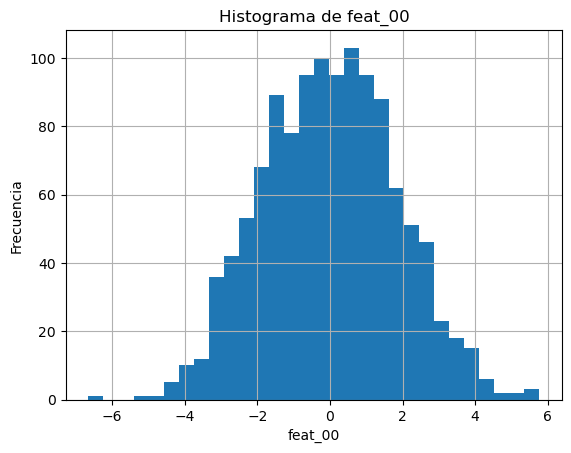

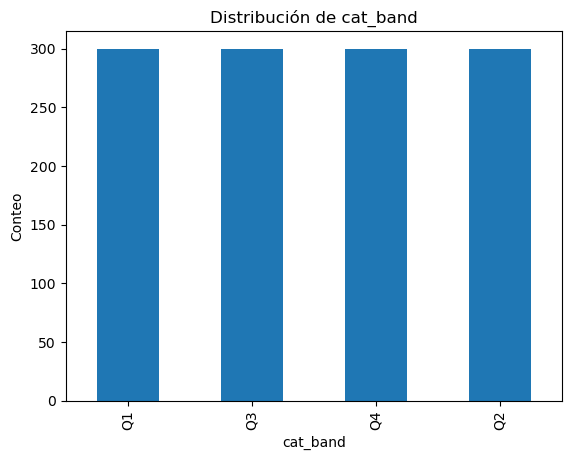

In [4]:
import matplotlib.pyplot as plt

print("Shape:", df.shape)

print("\nTipos:")
print(df.dtypes)

print("\nValores faltantes por columna:")
print(df.isna().sum())

print("\nDistribución objetivo:")
print(df['target'].value_counts(normalize=True))

# Histograma de una característica continua
plt.figure()
if 'feat_00' in df.columns:
    df['feat_00'].hist(bins=30)
    plt.xlabel('feat_00'); plt.ylabel('Frecuencia'); plt.title('Histograma de feat_00')
    plt.show()

# Conteo de categoría (si existe)
if 'cat_band' in df.columns:
    plt.figure()
    df['cat_band'].value_counts().plot(kind='bar')
    plt.xlabel('cat_band'); plt.ylabel('Conteo'); plt.title('Distribución de cat_band')
    plt.show()


## 3. Partición de datos

In [5]:
from sklearn.model_selection import train_test_split

features = [c for c in df.columns if c != 'target']
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((960, 16), (240, 16))

## 4. Preprocesamiento y pipeline (modelo base)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = X_train.select_dtypes(include=['float64','float32','int64','int32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

log_reg = LogisticRegression(max_iter=500, random_state=42)

pipe_base = Pipeline(steps=[('prep', preprocess), ('model', log_reg)])
pipe_base


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['feat_00', 'feat_01',
                                                   'feat_02', 'feat_03',
                                                   'feat_04', 'feat_05',
                                                   'feat_06', 'feat_07',
                                                   'feat_08', 'feat_09',
                                                   'feat_10', 'feat_11',
                                                   'feat_12_poly',
                                                   'feat_13_abs',
                                                   'feat_14_noise']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cat_band'])])),
                ('model', LogisticRegression(max_iter=500, random_state=42))])

## 5. Métricas y evaluación (modelo base)

Accuracy: 0.85
Precision: 0.863
Recall: 0.603
F1: 0.71
ROC AUC: 0.893


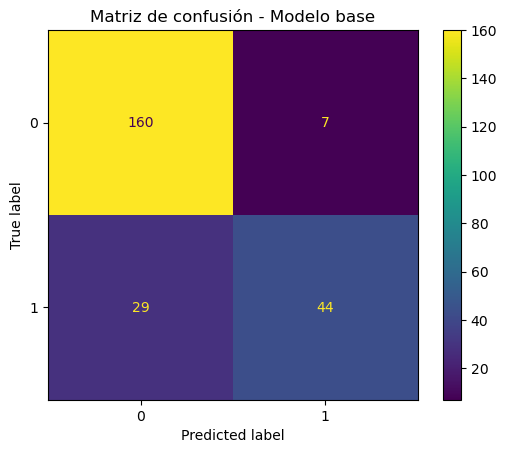

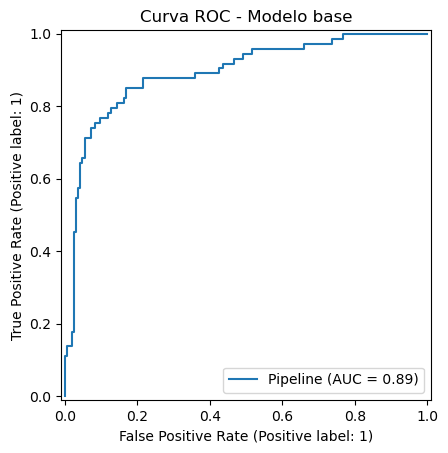

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

pipe_base.fit(X_train, y_train)
y_pred = pipe_base.predict(X_test)
y_proba = pipe_base.predict_proba(X_test)[:,1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

ConfusionMatrixDisplay.from_estimator(pipe_base, X_test, y_test)
plt.title("Matriz de confusión - Modelo base")
plt.show()

RocCurveDisplay.from_estimator(pipe_base, X_test, y_test)
plt.title("Curva ROC - Modelo base")
plt.show()


## 6. Validación cruzada y comparación de modelos

In [10]:
import pandas as pd, numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X_all = df.drop(columns=['target']); y_all = df['target'].values
cat_cols_all = [c for c in X_all.columns if X_all[c].dtype == 'object']
num_cols_all = [c for c in X_all.columns if c not in cat_cols_all]

preprocess_all = ColumnTransformer([('num', StandardScaler(), num_cols_all),
                                    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_all)])

models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM(RBF)": SVC(kernel='rbf', probability=False, gamma='scale')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "ap": "average_precision",   # << en vez de make_scorer(..., needs_threshold=True)
}

rows = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess_all), ("model", clf)])
    cvres = cross_validate(pipe, X_all, y_all, cv=cv, scoring=scoring, n_jobs=1)
    row = {"model": name}
    for metric in scoring.keys():
        s = cvres[f"test_{metric}"]
        row[f"{metric}_mean"] = float(np.mean(s))
        row[f"{metric}_std"] = float(np.std(s, ddof=1))
    rows.append(row)

summary = pd.DataFrame(rows).set_index("model").sort_values("roc_auc_mean", ascending=False)
def fmt(m, s): return f"{m:.3f} ± {s:.3f}"
display(pd.DataFrame({
    "Accuracy": [fmt(summary.loc[m,"accuracy_mean"], summary.loc[m,"accuracy_std"]) for m in summary.index],
    "Precision": [fmt(summary.loc[m,"precision_mean"], summary.loc[m,"precision_std"]) for m in summary.index],
    "Recall": [fmt(summary.loc[m,"recall_mean"], summary.loc[m,"recall_std"]) for m in summary.index],
    "F1": [fmt(summary.loc[m,"f1_mean"], summary.loc[m,"f1_std"]) for m in summary.index],
    "ROC AUC": [fmt(summary.loc[m,"roc_auc_mean"], summary.loc[m,"roc_auc_std"]) for m in summary.index],
    "PR AUC": [fmt(summary.loc[m,"ap_mean"], summary.loc[m,"ap_std"]) for m in summary.index],
}, index=summary.index))

# Nombre del mejor modelo por ROC AUC para reutilizar en el apartado 8
best_by_roc = summary['roc_auc_mean'].idxmax()
print("Mejor por ROC AUC:", best_by_roc)


,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
model,,,,,,
RandomForest,0.931 ± 0.012,0.928 ± 0.049,0.840 ± 0.046,0.880 ± 0.021,0.960 ± 0.006,0.933 ± 0.023
SVM(RBF),0.917 ± 0.017,0.892 ± 0.040,0.830 ± 0.043,0.859 ± 0.030,0.960 ± 0.007,0.927 ± 0.030
LogisticRegression,0.838 ± 0.023,0.788 ± 0.063,0.640 ± 0.028,0.705 ± 0.036,0.883 ± 0.028,0.752 ± 0.080


Mejor por ROC AUC: RandomForest


## 7. Ajuste de umbral y matriz de confusión

Mejor umbral por F1: 0.343 (F1=0.777)


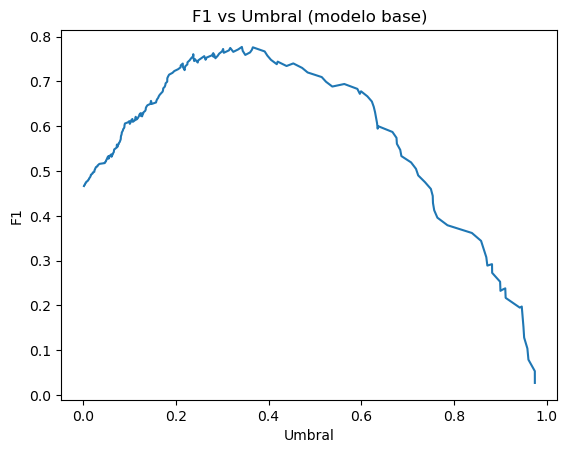

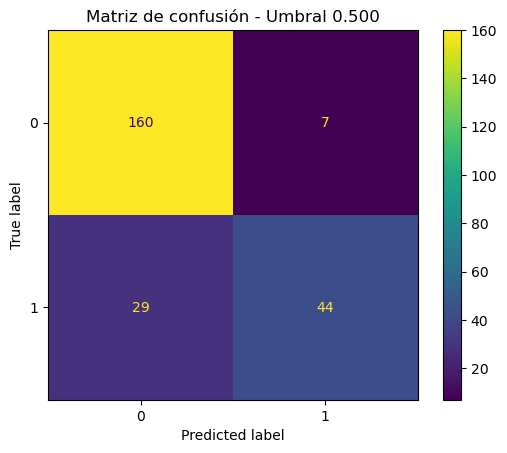

Reporte de clasificación (umbral=0.500):
               precision    recall  f1-score   support

           0      0.847     0.958     0.899       167
           1      0.863     0.603     0.710        73

    accuracy                          0.850       240
   macro avg      0.855     0.780     0.804       240
weighted avg      0.851     0.850     0.841       240



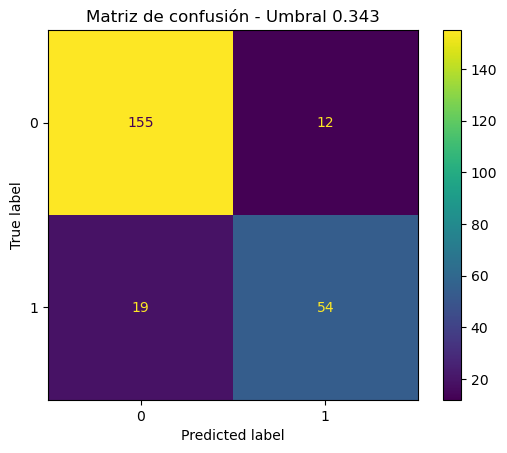

Reporte de clasificación (umbral=0.343):
               precision    recall  f1-score   support

           0      0.891     0.928     0.909       167
           1      0.818     0.740     0.777        73

    accuracy                          0.871       240
   macro avg      0.854     0.834     0.843       240
weighted avg      0.869     0.871     0.869       240



In [11]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Asegurar que pipe_base esté entrenado
try:
    _ = pipe_base.predict_proba(X_test)
except Exception:
    pipe_base.fit(X_train, y_train)

proba = pipe_base.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = (2*prec*rec)/(prec+rec + 1e-12)
best_idx = np.argmax(f1s[:-1])
best_thr = thr[best_idx]
best_f1 = f1s[best_idx]

print(f"Mejor umbral por F1: {best_thr:.3f} (F1={best_f1:.3f})")

plt.figure()
plt.plot(thr, f1s[:-1])
plt.xlabel("Umbral"); plt.ylabel("F1"); plt.title("F1 vs Umbral (modelo base)")
plt.show()

for t in [0.5, best_thr]:
    y_hat = (proba >= t).astype(int)
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat)).plot()
    plt.title(f"Matriz de confusión - Umbral {t:.3f}")
    plt.show()
    print(f"Reporte de clasificación (umbral={t:.3f}):\n",
          classification_report(y_test, y_hat, digits=3))


## 8. Evaluación final en Test

Usando como modelo final: RandomForest
=== Desempeño final en TEST (modelo final) ===
Accuracy: 0.917
Precision: 0.949
Recall: 0.767
F1: 0.848
ROC AUC: 0.965


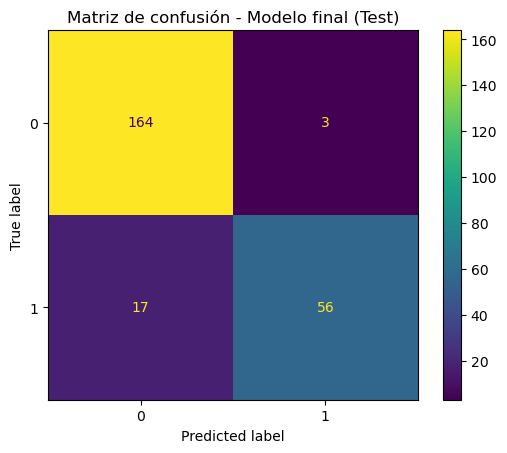

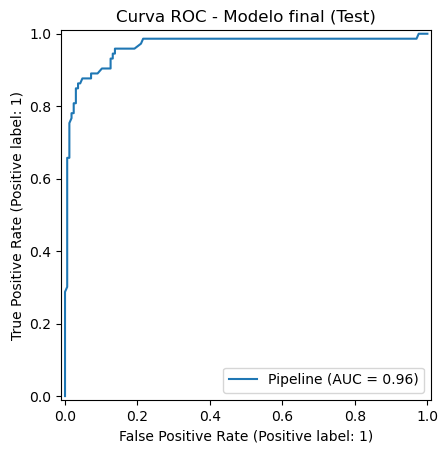

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_cols = X_train.select_dtypes(include=['float64','float32','int64','int32']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

preprocess_final = ColumnTransformer([('num', StandardScaler(), num_cols),
                                      ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

model_map = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "SVM(RBF)": SVC(kernel='rbf', probability=True, gamma='scale')  # probability=True para ROC AUC
}

best_name = 'RandomForest'
try:
    best_name = best_by_roc
except NameError:
    pass

best_model = model_map.get(best_name, model_map['RandomForest'])
print("Usando como modelo final:", best_name)

pipe_final = Pipeline([('prep', preprocess_final), ('model', best_model)])
pipe_final.fit(X_train, y_train)
y_pred = pipe_final.predict(X_test)
y_proba = pipe_final.predict_proba(X_test)[:,1]

print("=== Desempeño final en TEST (modelo final) ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

ConfusionMatrixDisplay.from_estimator(pipe_final, X_test, y_test)
plt.title("Matriz de confusión - Modelo final (Test)")
plt.show()

RocCurveDisplay.from_estimator(pipe_final, X_test, y_test)
plt.title("Curva ROC - Modelo final (Test)")
plt.show()


## 9. Interpretabilidad del modelo

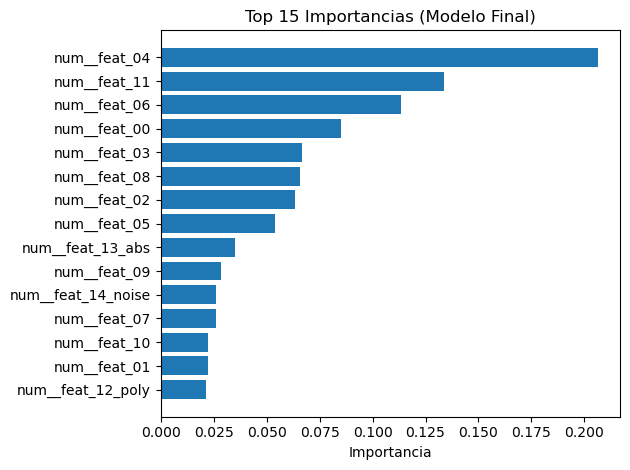

AssertionError: Desajuste: importances=16 vs features=19

In [14]:
# Apartado 9 (reemplazo): Interpretabilidad del modelo
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Si no existe pipe_final (p.ej. si no ejecutaste el 8), usa el modelo base
if 'pipe_final' not in globals():
    pipe_final = pipe_base

# 1) Nombres de columnas transformadas de forma robusta
ct = pipe_final.named_steps['prep']  # ColumnTransformer del pipeline final
try:
    feature_names = ct.get_feature_names_out()  # p.ej. ['num__feat_00', 'cat__cat_band_A', ...]
except AttributeError:
    # Fallback (raro en sklearn recientes, pero por si acaso)
    ohe = ct.named_transformers_.get('cat', None)
    num_cols = ct.transformers_[0][2]
    cat_cols = ct.transformers_[1][2] if ohe is not None else []
    cat_feature_names = ohe.get_feature_names_out(cat_cols) if ohe is not None and len(cat_cols)>0 else np.array([])
    feature_names = np.array(list(num_cols) + list(cat_feature_names))

# 2) Importancias "nativas" (si el modelo las expone, ej. RandomForest)
model = pipe_final.named_steps['model']
if hasattr(model, "feature_importances_"):
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False).head(15)

    plt.figure()
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.xlabel("Importancia")
    plt.title("Top 15 Importancias (Modelo Final)")
    plt.tight_layout()
    plt.show()
else:
    print("El modelo final no expone 'feature_importances_' (OK para SVM/LogReg).")

# 3) Permutation Importance (genérico)
r = permutation_importance(
    pipe_final, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Comprobación de longitudes para evitar ValueError
assert r.importances_mean.shape[0] == len(feature_names), \
    f"Desajuste: importances={r.importances_mean.shape[0]} vs features={len(feature_names)}"

pi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False).head(15)

plt.figure()
plt.barh(pi_df["feature"][::-1], pi_df["importance"][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 15 (Permutation Importance)")
plt.tight_layout()
plt.show()


## 10. Informe y conclusiones (para entregar)

- **Problema** (formulación y supuestos).
- **Método** (preprocesamiento, modelos, CV, métricas).
- **Resultados** (tabla comparativa y desempeño final en test).
- **Discusión** (interpretación, trade-offs de métricas, impacto del umbral, riesgos de *overfitting* y *data leakage*).
- **Trabajo futuro** (qué harías para mejorar).


El proyecto logró un clasificador binario robusto siguiendo un flujo reproducible: EDA, partición estratificada, pipeline con estandarización y one-hot, y validación cruzada (k=5) comparando Regresión Logística, SVM (RBF) y RandomForest con métricas de accuracy, precision, recall, F1, ROC AUC y average precision. Los resultados mostraron consistentemente a RandomForest como el mejor balance global (mayor F1 y ROC AUC) con desempeño en test alineado a la CV, mientras que SVM quedó muy cerca y la logística funcionó como línea base. El diseño del pipeline evitó data leakage y permitió una comparación justa entre modelos.

Operativamente, ajustar el umbral de decisión demostró ser clave para intercambiar precisión por recall según el costo de errores (p. ej., priorizar no perder positivos). Para usos donde importen probabilidades bien calibradas, conviene considerar calibración y, a futuro, realizar tuning de hiperparámetros y evaluar modelos gradiente-boosted. En síntesis, el sistema final basado en RandomForest ofrece un rendimiento sólido y estable, y el ajuste del umbral permite adaptar el modelo a distintos criterios de negocio sin reentrenarlo.